In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [244]:
config = {
    'input_dim': 2,
    'num_samples': 56,
    'distribution': 'normal', # 'normal' or 'uniform'
    'lr': 5e-3,
    'min_lr': 1e-4,
    'epochs': 10000,
    'patience': 100,
    'device': device,
    'batch_size': 128,
}

In [15]:
# SwiGLU Activation Unit
# from this repo 
# https://github.com/lucidrains/PaLM-pytorch/blob/main/palm_pytorch/palm_pytorch.py#L61

class SwiGLU(nn.Module):
    def forward(self, x):
        x, gate = x.chunk(2, dim=-1)
        return F.silu(gate) * x

In [16]:
class MLP_BinaryClassification(nn.Module):
    """
    GPT-like MLP with a binary classification head on top of it
    I follow nanoGPT naming for clarity
    """
    def __init__(self, input_dim,  expansion_factor=4, bias=True):
        super(MLP_BinaryClassification, self).__init__()
        self.c_fc = nn.Linear(input_dim, input_dim * expansion_factor, bias=bias)
        self.c_proj = nn.Linear(input_dim * expansion_factor, input_dim, bias=bias)
        self.binary_head = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        x = self.c_fc(x)
        x = F.gelu(x)  # the formula cited in torch docs is the same as new_gelu
        x = self.c_proj(x)
        x = self.binary_head(x)
        x = torch.sigmoid(x)
        return x
    

    
class SwiGLU_BinaryClassification(nn.Module):
    """
    SwiGLU FFD with a binary classification head on top of it
    I use the same scaling  2/3 * 4 * hidden_dim 
    as the Llama paper https://arxiv.org/pdf/2302.13971.pdf
    """
    def __init__(self, input_dim, expansion_factor=4):
        super(SwiGLU_BinaryClassification, self).__init__()
        self.hidden_dim = input_dim * expansion_factor * 2 // 3 
        self.c_fc = nn.Linear(input_dim, self.hidden_dim * 2)   # x2 for SwiGLU
        self.swiglu = SwiGLU()
        self.c_proj = nn.Linear(self.hidden_dim, input_dim)
        self.binary_head = nn.Linear(input_dim, 1)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.swiglu(x)
        x = self.c_proj(x)
        x = self.binary_head(x)
        x = torch.sigmoid(x)
        return x

In [17]:
class random_dataset(Dataset):
    def __init__(self, config, specific_data=None):
        if specific_data is not None:
            self.inputs = specific_data[0]
            self.labels = specific_data[1]
        else:
            if config['distribution'] == 'uniform':
                self.inputs = torch.rand(config['num_samples'], config['input_dim'])
            elif config['distribution'] == 'normal':
                self.inputs = torch.randn(config['num_samples'], config['input_dim'])
            self.labels = torch.randint(0, 2, (config['num_samples'],)).float()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]


In [184]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

def test_model(model, dataloader, criterion, device):
    # model.eval() # we don't have dropout or batchnorm
    test_loss = 0
    accuracy = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            test_loss += criterion(y_hat, y.unsqueeze(-1)).item()
            accuracy += binary_acc(y_hat, y.unsqueeze(-1)).item()

    return test_loss / len(dataloader), accuracy / len(dataloader)

In [245]:
def prepare_model(config, modeltype, **kwargs):
    # update config with kwargs
    config = {**config, **kwargs}
    if modeltype == 'MLP':
        model = MLP_BinaryClassification(config['input_dim'])
    elif modeltype == 'SwiGLU':
        model = SwiGLU_BinaryClassification(config['input_dim'])
    else:
        raise ValueError('modeltype must be either GPT or SwiGLU')
    num_param = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Number of parameters: {num_param}')

    return model

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    train_loss = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat, y.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(dataloader) #TODO handle the last batch


def train_model(model, dataloader, config, device, verbose = True, **kwargs):
    # update config with kwargs
    config = {**config, **kwargs}

    num_epochs = config['epochs']
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=config['min_lr'])

    
    for epoch in range(num_epochs):
        loss = train_one_epoch(model, dataloader, criterion, optimizer, device)
        if verbose:
            if epoch % (num_epochs // 10) == 0:
                print(f'Epoch {epoch} | lr: {scheduler.get_last_lr()[0]:.5f} | Train Loss: {loss:.5f} ')
        scheduler.step()

    loss, accuracy = test_model(model, dataloader, criterion, device)
    print(f'Loss: {loss:.5f} | Accuracy: {accuracy:.2f}')
    return loss, accuracy

In [159]:
def classifier_plot(dataloader, model, device):
    criterion = nn.BCELoss()
    loss, accuracy = test_model(model, dataloader, criterion, device)

    x0,y0 = next(iter(dataloader)) # the training points
    xs = x0.detach().cpu().numpy()
    ys = y0.detach().cpu().numpy()
    x_min = min(1.15*xs[:, 0].min(), 0.85*xs[:, 0].max())
    x_max = 1.15*xs[:, 0].max()
    y_min = min(1.15*xs[:, 1].min(), 0.85*xs[:, 1].max())
    y_max = 1.15*xs[:, 1].max()
    print(x_min, x_max, y_min, y_max)
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                     np.linspace(y_min, y_max, 1000))
    with torch.no_grad():
        Z = model(torch.Tensor(np.c_[xx.ravel(), yy.ravel()]).to(device))
    Z = torch.round(Z)
    Z = Z.cpu().detach().numpy()

    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, levels=[0.0, 0.5, 1.0], alpha=0.5, colors=['#FFCCCC', '#CCFFCC'])

    plt.scatter(xs[:,0], xs[:,1], s=10, c=ys, cmap='RdYlGn', marker='o', alpha=0.8)
    text_x = x_min + (x_max - x_min)*0.02
    text_y = y_max - (y_max - y_min)*0.02
    plt.text(text_x, text_y*0.95, f'Loss: {loss:.2f}', fontsize=10)
    plt.text(text_x, text_y*0.85, f'Accuracy: {accuracy:.2f}%', fontsize=10)

    plt.xlim(x_min,x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('x[:,0]')
    plt.ylabel('x[:,1]')

    plt.title(model.__class__.__name__)

    plt.show()

In [206]:
def compute_padding(xs, ys, padding=0.1):
    x_range = xs[:, 0].max() - xs[:, 0].min()
    y_range = xs[:, 1].max() - xs[:, 1].min()

    padding_x = x_range * padding
    padding_y = y_range * padding

    x_min = xs[:, 0].min() - padding_x
    x_max = xs[:, 0].max() + padding_x
    y_min = xs[:, 1].min() - padding_y
    y_max = xs[:, 1].max() + padding_y

    return x_min, x_max, y_min, y_max

def classifier_plot(dataloader, model, device):
    criterion = nn.BCELoss()
    loss, accuracy = test_model(model, dataloader, criterion, device)

    x0, y0 = next(iter(dataloader))  # the training points
    xs = x0.detach().cpu().numpy()
    ys = y0.detach().cpu().numpy()

    x_min, x_max, y_min, y_max = compute_padding(xs, ys)

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                         np.linspace(y_min, y_max, 1000))
    
    with torch.no_grad():
        Z = model(torch.Tensor(np.c_[xx.ravel(), yy.ravel()]).to(device))
    
    Z = torch.round(Z)
    Z = Z.cpu().detach().numpy()
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, levels=[0.0, 0.5, 1.0], alpha=0.5, colors=['#FFCCCC', '#CCFFCC'])
    plt.scatter(xs[:, 0], xs[:, 1], s=10, c=ys, cmap='RdYlGn', marker='o', alpha=0.8)

    # Set limits before placing text
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    # Place text relative to the axis limits
    text_x = x_min + (x_max - x_min) * 0.02
    text_y = y_max - (y_max - y_min) * 0.02

    plt.text(text_x, text_y * 0.95, f'Loss: {loss:.2f}', fontsize=10)
    plt.text(text_x, text_y * 0.85, f'Accuracy: {accuracy:.2f}%', fontsize=10)

    plt.xlabel('x[:,0]')
    plt.ylabel('x[:,1]')
    num_param = sum(p.numel() for p in model.parameters() if p.requires_grad)
    plt.title(f"{model.__class__.__name__.split('_')[0]} | {num_param} parameters | {config['num_samples']} samples")

    fig = plt.gcf()
    plt.show()

    return fig


In [180]:
config = {
    'input_dim': 2,
    'num_samples': 56,
    'distribution': 'normal', # 'normal' or 'uniform'
    'lr': 2e-3,
    'epochs': 10000,
    'patience': 100,
    'device': device,
    'batch_size': 128,
}

dataset = random_dataset(config)
dataloader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)

In [192]:
model1 = prepare_model(config, 'SwiGLU')
model2 = prepare_model(config, 'MLP')

Number of parameters: 45
Number of parameters: 45


In [182]:
train_model(model1, dataloader, config, device, verbose = True)
train_model(model2, dataloader, config, device, verbose = True)

Epoch 0 | lr: 0.00200 | Train Loss: 0.73245 
Epoch 1000 | lr: 0.00195 | Train Loss: 0.49901 
Epoch 2000 | lr: 0.00182 | Train Loss: 0.44611 
Epoch 3000 | lr: 0.00161 | Train Loss: 0.32448 
Epoch 4000 | lr: 0.00134 | Train Loss: 0.24122 
Epoch 5000 | lr: 0.00105 | Train Loss: 0.22204 
Epoch 6000 | lr: 0.00076 | Train Loss: 0.18598 
Epoch 7000 | lr: 0.00049 | Train Loss: 0.16353 
Epoch 8000 | lr: 0.00028 | Train Loss: 0.15302 
Epoch 9000 | lr: 0.00015 | Train Loss: 0.14766 
Loss: 0.14430 | Accuracy: 96.00
Epoch 0 | lr: 0.00200 | Train Loss: 0.73530 
Epoch 1000 | lr: 0.00195 | Train Loss: 0.47930 
Epoch 2000 | lr: 0.00182 | Train Loss: 0.33097 
Epoch 3000 | lr: 0.00161 | Train Loss: 0.28848 
Epoch 4000 | lr: 0.00134 | Train Loss: 0.25414 
Epoch 5000 | lr: 0.00105 | Train Loss: 0.20539 
Epoch 6000 | lr: 0.00076 | Train Loss: 0.18150 
Epoch 7000 | lr: 0.00049 | Train Loss: 0.16774 
Epoch 8000 | lr: 0.00028 | Train Loss: 0.15859 
Epoch 9000 | lr: 0.00015 | Train Loss: 0.15302 
Loss: 0.14956 

(0.14956310391426086, 93.0)

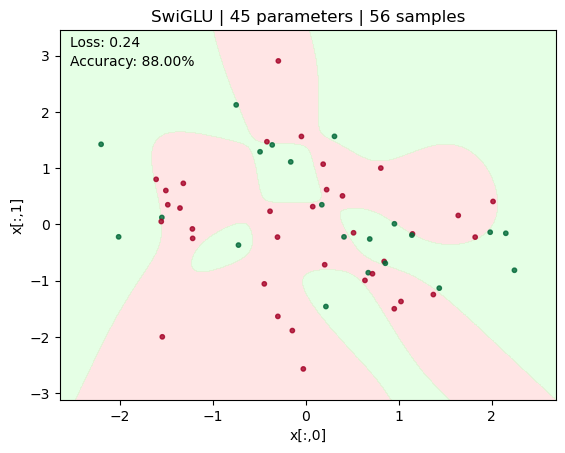

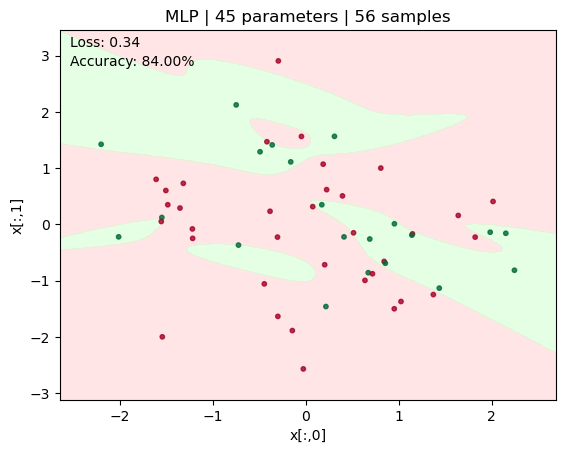

In [207]:
fig1 = classifier_plot(dataloader, model1, device)
fig2 = classifier_plot(dataloader, model2, device)

# Animation

### Animation function
Should be refactored

In [246]:
import matplotlib.animation as animation

def make_animations(config, dataloader, modeltype, device, **kwargs):
    config = {**config, **kwargs}
    # create model
    if modeltype == 'MLP':
        model = MLP_BinaryClassification(config['input_dim'])
    elif modeltype == 'SwiGLU':
        model = SwiGLU_BinaryClassification(config['input_dim'])

    num_param = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # these are training points, will be shown by dots
    x0,y0 = next(iter(dataloader))
    xs = x0.detach().cpu().numpy()
    ys = y0.detach().cpu().numpy()

    x_min, x_max, y_min, y_max = compute_padding(xs, ys)

    # Generate the meshgrid for the decision boundary
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                        np.linspace(y_min, y_max, 300))


    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])

    # every frame will more and more epochs
    skip_epochs_coef = config['skip_epochs_coef']
    frames = config['frames']
    total_steps = skip_epochs_coef//2 * frames * (frames+1)

    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=config['min_lr'])
    


    def update(frame, model, dataloader, criterion, optimizer, device, skip_epochs_coef):
        if frame == 0:  # Skip frame 0 to prevent loop back in animation
            return
        current_loss, accuracy = test_model(model, dataloader, criterion, device)
        current_epoch = skip_epochs_coef//2 * frame * (frame+1)

        # labels on the grid
        with torch.no_grad():
            Z = model(torch.Tensor(np.c_[xx.ravel(), yy.ravel()]).to(device))
        Z = Z.cpu().detach().numpy()
        Z = Z.reshape(xx.shape)
        
        plt.clf()
        plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.8, colors=['#FFCCCC', '#CCFFCC'])
        
        plt.scatter(xs[:,0], xs[:,1], s=10, c=ys, cmap='RdYlGn', marker='o', alpha=0.8)

        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.xlabel('x[:,0]')
        plt.ylabel('x[:,1]')

        plt.title(f"{model.__class__.__name__.split('_')[0]} | {num_param} parameters | {config['num_samples']} samples")

        text_x = x_min + (x_max - x_min) * 0.02
        text_y = y_max - (y_max - y_min) * 0.02


        plt.text(text_x, text_y * 0.95, f'Epoch: {current_epoch}', fontsize=10)
        plt.text(text_x, text_y * 0.85, f'Train Loss: {current_loss:.2f}', fontsize=10)
        plt.text(text_x, text_y * 0.75, f'Accuracy: {accuracy:.2f}%', fontsize=10)

        # train for more epochs
        # increases with frame number (tootal num epochs is quadratic in frame number)
        for _ in range(skip_epochs_coef*frame):
            train_one_epoch(model, dataloader, criterion, optimizer, device)
            scheduler.step()

    fig, ax = plt.subplots(figsize=(6,6))



    ani = animation.FuncAnimation(fig, update, frames=frames, 
                                fargs=(model, dataloader, criterion, optimizer, device, skip_epochs_coef),
                                interval=config['interval'])

    output = './assets/' + model.__class__.__name__+ '.gif'
    ani.save(output, writer='pillow')


### Animations

In [267]:
torch.manual_seed(2023)
#FIXME should also affect model intialization

In [268]:
config = {
    'input_dim': 2,
    'num_samples': 56,
    'distribution': 'normal', # 'normal' or 'uniform'
    'lr': 5e-3,
    'min_lr': 1e-3,
    'epochs': 10000,
    'patience': 100,
    'device': device,
    'batch_size': 128,
    'skip_epochs_coef': 2,
    'frames': 100,
    'interval': 200, #ms
}

dataset = random_dataset(config)
dataloader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)


**First let's get the static plots**
Some datasets are could be very tricky and may need longer training, which means longer gifs.


Number of parameters: 45
Number of parameters: 45
Epoch 0 | lr: 0.00500 | Train Loss: 0.71598 
Epoch 1000 | lr: 0.00490 | Train Loss: 0.00443 
Epoch 2000 | lr: 0.00462 | Train Loss: 0.00047 
Epoch 3000 | lr: 0.00418 | Train Loss: 0.00016 
Epoch 4000 | lr: 0.00362 | Train Loss: 0.00007 
Epoch 5000 | lr: 0.00300 | Train Loss: 0.00004 
Epoch 6000 | lr: 0.00238 | Train Loss: 0.00002 
Epoch 7000 | lr: 0.00182 | Train Loss: 0.00002 
Epoch 8000 | lr: 0.00138 | Train Loss: 0.00001 
Epoch 9000 | lr: 0.00110 | Train Loss: 0.00001 
Loss: 0.00001 | Accuracy: 100.00
Loss: 0.08225 | Accuracy: 98.00


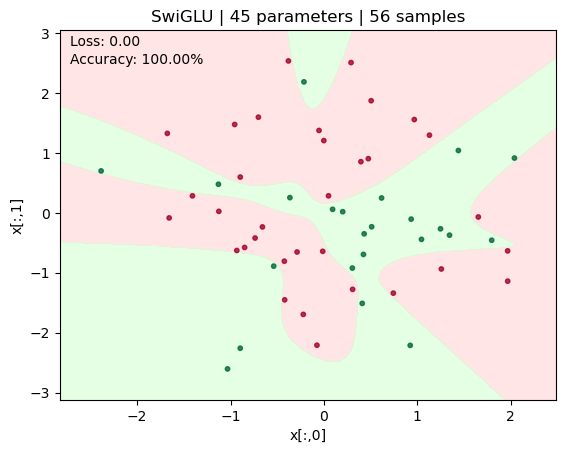

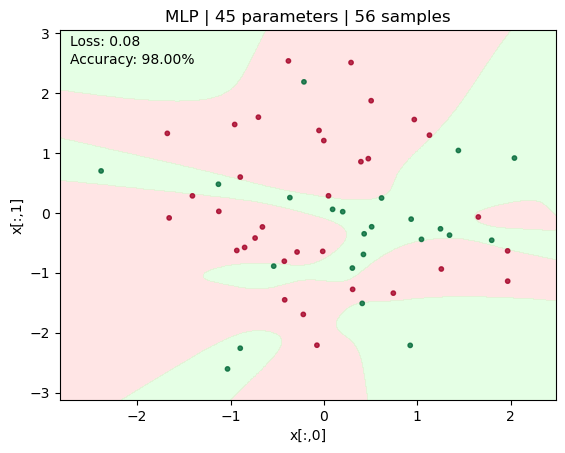

In [270]:
model1 = prepare_model(config, 'SwiGLU')
model2 = prepare_model(config, 'MLP')
train_model(model1, dataloader, config, device, verbose = True)
train_model(model2, dataloader, config, device, verbose = False)
fig1 = classifier_plot(dataloader, model1, device)
fig2 = classifier_plot(dataloader, model2, device)

In [273]:
fig1.savefig('./assets/swiglu.pdf',bbox_inches='tight')
fig2.savefig('./assets/mlp.pdf',bbox_inches='tight')

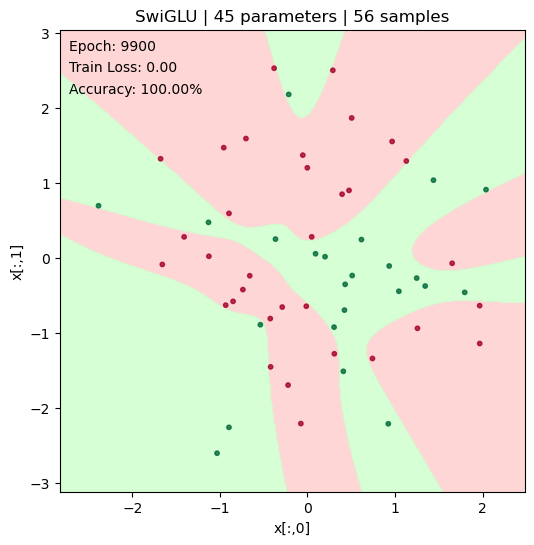

In [271]:
make_animations(config, dataloader, 'SwiGLU', device)

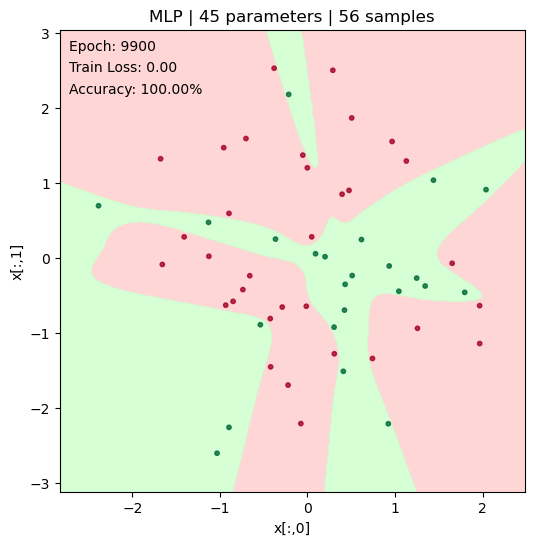

In [272]:
make_animations(config, dataloader, 'MLP', device)